##### Metody obliczeniowe w nauce i technice

## Laboratorium 13 - Minimalizacja funkcji

### Sprawozdanie sporządził: Marcin Zielonka

### Wstęp

Do realizacji zadań skorzystam z gotowych funkcjonalności zawartych w bibliotekach:
- `numpy` - wersja `1.18.2`
- `matplotlib` - wersja `3.2.0`
- `networkx` - wersja `2.4`
- `math`
- `random`

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import random
import networkx as nx

### Zadanie 1: Problem komiwojażera

Wygeneruj chmurę n losowych punktów w 2D, a następnie zastosuj algorytm symulowanego wyżarzania do przybliżonego rozwiązania problemu komiwojażera dla tych punktów

1. Przedstaw wizualizację otrzymanego rozwiązania dla 3 różnych wartości n oraz 3 różnych układów punktów w 2D (rozkład jednostajny, rozkład normalny z czterema różnymi grupami parametrów, dziewięć odseparowanych grup punktów).
2. Zbadaj wpływ sposobu generacji sąsiedniego stanu (consecutive swap - zamiana kolejności losowej pary połączonych wierzchołków w ścieżce vs. arbitrary swap - zamiana dwóch losowych wierzchołków w ścieżce) oraz początkowej wartości temperatury na zbieżność procesu optymalizacji.
3. Przedstaw wizualizację działania procedury minimalizującej funkcję celu (funkcja przekazana do metody dual annealing może modyfikować zewnątrzny stan)

Na początku napisałem funkcję, która generuje chmurę $n$ losowych punktów na płaszczyźnie wg przekazanego jako `mode` sposobu rozkładu chmury punktów:
- `uniform` - rozkład jednostajny chmury punktów
- `normal4` - rozkład normalny z czterema róznymi grupami parametrów
- `separate9` - dziewięć odseparowanych grup punktów (też na podst. rozkładu normalnego)

In [2]:
def generate_points(n, mode):
    result = []
    
    if mode == 'uniform':
        for i in range(n):
            result.append((np.random.randint(-500, 500), np.random.randint(-500, 500)))
    
    if mode == 'normal4':
        params = [(-250, -250, 30), (-250, 250, 80), (250, -250, 120), (250, 250, 200)]
        
        for mi_x, mi_y, sigma in params:
            for i in range(math.floor(n / 4)):
                result.append(
                    (random.normalvariate(mi_x, sigma), 
                     random.normalvariate(mi_y, sigma))
                )
    
    if mode == 'separate9':
        params = [
            (-250, -250, 20),
            (-250, 0, 20),
            (-250, 250, 20),
            (0, -250, 20),
            (0, 0, 20),
            (0, 250, 20),
            (250, -250, 20),
            (250, 0, 20),
            (250, 250, 20)
        ]
        
        for mi_x, mi_y, sigma in params:
            for i in range(math.floor(n / 9)):
                result.append(
                    (random.normalvariate(mi_x, sigma), 
                     random.normalvariate(mi_y, sigma))
                )
    
    return result

Następnie przystąpiłem do implementacji funkcji, która realizuje symulowane wyżarzanie na przykładzie problemu komiwojażera. Funkcję tę oraz wszystkie funkcje pomocnicze zaimplementowałem z wykorzystaniem informacji zawartych na stronach:
- https://towardsdatascience.com/optimization-techniques-simulated-annealing-d6a4785a1de7
- https://en.wikipedia.org/wiki/Simulated_annealing

Przed zaimplementowaniem głównej funkcji, napisałem kilka funkcji pomocniczyć, które pozwalają otrzymać niezbędne dane do poprawnego działania algorytmu symulowanego wyżarzania:

Pierwszą z nich jest funkcja kosztu, która na podstawie dwóch parametrów:
- `path` - ścieżka; lista wierzchołków, przez którego kolejną ma przechodzić ścieżka
- `points` - lista punktów na płaszczyźnie

Na tej podstawie wyliczana jest całkowita długość przekazanej ścieżki.

In [3]:
def cost(path, points):
    n = len(path)
    sum = 0
    
    previous = path[len(path) - 1]
    current = path[0]
    
    for i in path:
        current = i
        sum += np.sqrt(
            (points[current][0] - points[previous][0]) ** 2 + 
            (points[current][1] - points[previous][1]) ** 2)
        previous = current
    
    return sum

Drugą funkcją pomocniczą jest funkcja, która losuje wg przekazanego w argumencie sposobu, nową ścieżkę na podstawie już istniejącej. Do wyboru są dwa tryby wygenerowania nowej ścieżki:
- `consecutive` - zamiana miejscami dwóch połączonych ze sobą wierzchołków
- `arbitrary` - zamiana miejscami dwóch losowych wierzchołków

Funkcja ta zwraca wygenerowaną nową ścieżkę w postaci listy kolejnych wierzchołków.

In [4]:
def neighbour(S, mode):
    N = S.copy()
    
    p1 = 0
    p2 = 0
    
    if mode == 'consecutive':
        p1 = np.random.randint(len(N))
        p2 = (p1 + 1) % len(N)
    elif mode == 'arbitrary':
        p1 = np.random.randint(len(N))
        p2 = np.random.randint(len(N))
        
        while p1 == p2:
            p2 = np.random.randint(len(N))
    
    N[p1], N[p2] = N[p2], N[p1]
    
    return N

Trzecią funkcją pomocniczą jest funkcja realizująca sprawdzenie czy pomimo większego kosztu, stan ma zostać zamieniony na ten z wyższym kosztem. Funkcja ta przyjmuje następujące parametry:
- `delta` - różnica kosztów pomiędzy dwoma stanami
- `t` - aktualna temperatura

Funkcja ta pełni rolę funkcji prawdopodobieństwa wg poniższego wzoru:

$$P(\Delta{E};T)=e^{-\frac{\Delta{E}}{T}}$$

In [5]:
def do_switch_neighbour(delta, t):
    return random.uniform(0, 1) < math.e ** (-delta / t)

Następnie, wykorzystując poprzedno zaimplementowane funkcje pomocnicze, napisałem funkcję, która zwraca rozwiązanie problemu komiwojażera przy użyciu algorytmu symulowanego wyżarzania:

Jako parametry przekazujemy do funkcji:
- `points` - lista wszystkich punktów na płaszczyźnie
- `t0` - temperatura początkowa
- `mode` - sposób generowania nowego stanu
- `t_min` - docelowa temperatura, przy której algorytm ma zakończyć działanie

W zaimplementowanej funkcji, temperatura maleje w sposób geometryczny, zgodnie ze wzorem:
$$ T_{k+1}=\alpha\cdot{T_{k}},\alpha=10^{-25}$$

In [6]:
def simulated_annealing(points, t0, mode, t_min=1e-30):    
    path = np.arange(0, len(points), 1)
    t = t0
    
    while t >= t_min:
        t *= 1e-25
        new_path = neighbour(path, mode)
        
        cost_current = cost(path, points)
        cost_new = cost(new_path, points)
        
        delta = cost_new - cost_current
        
        if delta > 0:
            path = new_path
        elif do_switch_neighbour(delta / delta, t):
            path = new_path
    
    return path, cost(path, points)

W celu wizualizacji otrzymanych wyników, wykorzystałem bibliotekę do tworzenia grafów - `networkx`. W tym celu utworzyłem dwie funkcje pomocznicze, które tworzą graf na podstawie dostarczonej listy punktów i ścieżki, a następnie wyświetlają wizualizację tego grafu:

In [7]:
def show_graph(G, attribute, pos):
    nx.draw_networkx_edge_labels(
        G, 
        pos=pos, 
        edge_labels=nx.get_edge_attributes(G, attribute)
    )
    
    nx.draw(
        G, 
        pos=pos,
        node_size=150,
        font_size=8,
        with_labels=True
    )

In [8]:
def show_path(path, points):
    G = nx.Graph()
    
    for i in range(len(points)):
        G.add_node(i)
    
    previous = path[len(path) - 1]
    current = path[0]
    
    for i in path:
        current = i
        G.add_edge(previous, current)
        previous = current
    
    pos = {idx: [x, y] for idx, (x, y) in enumerate(points)}
    
    show_graph(G, '', pos=pos)

Na końcu utworzyłem funkcję, która na podstawie ilości i sposobu generowania punktów, temperatury początkowej oraz sposobie generowania nowych stanów, generuje wynik w postaci ścieżki i wyświetla ten wynik w postaci grafu:

In [9]:
def show_results(n, points_mode, t0, mode):
    points = generate_points(n, points_mode)
    path, cost = simulated_annealing(points, t0, mode)
    
    show_path(path, points)
    print(f'cost: {cost}')

Wyniki dla poszczególnych parametrów:

dla $n=36$ przy jednostajnym rozkładzie punktów:

cost: 15533.449214680433


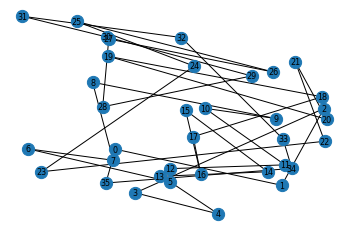

In [10]:
show_results(36, 'uniform', 50, mode='consecutive')

dla $n=36$ przy normalnym rozkładzie dla 4 grup punktów:

cost: 8692.552459549013


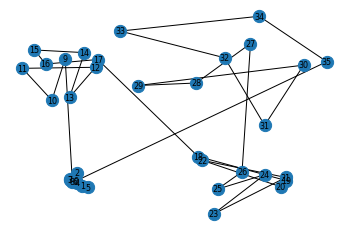

In [11]:
show_results(36, 'normal4', 50, mode='consecutive')

dla $n=36$ przy rozkładzie na 9 odseparowanych grup punktów:

cost: 4277.401075471324


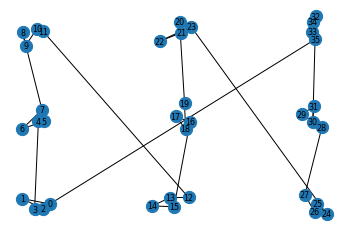

In [12]:
show_results(36, 'separate9', 50, mode='consecutive')

dla $n=72$ przy jednostajnym rozkładzie punktów:

cost: 38639.61610826838


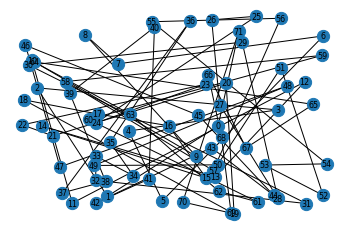

In [13]:
show_results(72, 'uniform', 50, mode='consecutive')

dla $n=72$ przy normalnym rozkładzie dla 4 grup punktów:

cost: 15360.264896463286


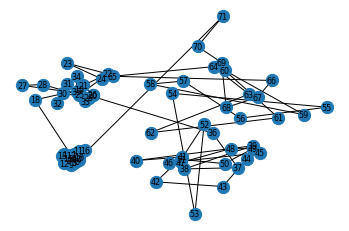

In [14]:
show_results(72, 'normal4', 50, mode='consecutive')

dla $n=72$ przy rozkładzie na 9 odseparowanych grup punktów:

cost: 5608.297561678717


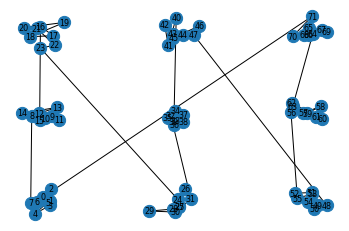

In [15]:
show_results(72, 'separate9', 50, mode='consecutive')

dla $n=288$ przy jednostajnym rozkładzie punktów:

cost: 145576.83862019048


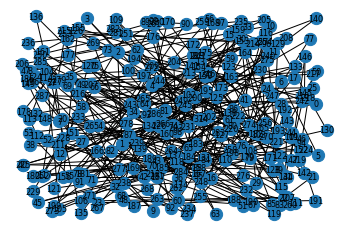

In [16]:
show_results(288, 'uniform', 50, mode='consecutive')

dla $n=288$ przy normalnym rozkładzie dla 4 grup punktów:

cost: 55866.2765706746


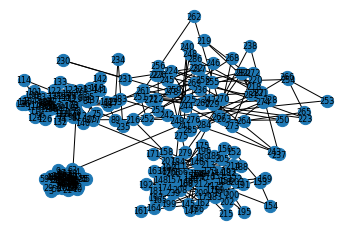

In [17]:
show_results(288, 'normal4', 50, mode='consecutive')

dla $n=288$ przy rozkładzie na 9 odseparowanych grup punktów:

cost: 13897.801543697475


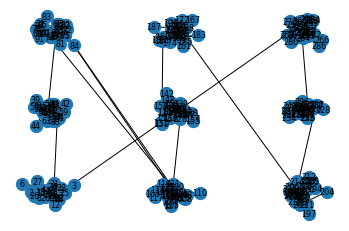

In [18]:
show_results(288, 'separate9', 50, mode='consecutive')

Jak widzimy, zaimplementowana funkcja działa poprawanie. Jest to przede wszystkim zauważalne dla chmur grup punktów, ponieważ widzimy, że ścieżka zostaje wyznaczona najpierw w obrębie poszczególnych grup, a dopiero wtedy przechodzi do następnej (tj. grupy).

Na końcu sprawdziłem jak temperatura początkowa oraz sposób generowania nowego stanu wpływa na proces optymalizacji. W tym celu wykonałem wizualizację wyników dla $n=72$ przy rozkładzie dla 4 różnych grup punktów.

W tym celu napisałem dodatkową funkcję, która wyświetla na wykresie średni całkowity koszt w zależności od zastosowanych wartości parametrów temperatury i sposobu generowania nowego stanu:

In [19]:
def check_parameters(points, max_temp, attempts_per_once=10):
    ts = np.arange(5, max_temp + 1, 1)
    
    consecutive = []
    arbitrary = []
    
    for t in ts:
        arbitrary_sum = 0
        consecutive_sum = 0
        
        for i in range(attempts_per_once):
            _, consecutive_cost = simulated_annealing(points, t, mode='consecutive')
            _, arbitrary_cost = simulated_annealing(points, t, mode='arbitrary')
            
            consecutive_sum += consecutive_cost
            arbitrary_sum += arbitrary_cost
        
        consecutive.append(consecutive_sum / attempts_per_once)
        arbitrary.append(arbitrary_sum /attempts_per_once)
    
    plt.plot(ts, consecutive, 'b')
    plt.plot(ts, arbitrary, 'g')
    
    plt.show()   

Otrzymane wyniki (kolor niebieski oznacza sposób `consecutive-swap`, a kolor zielony `arbitrary-swap`):

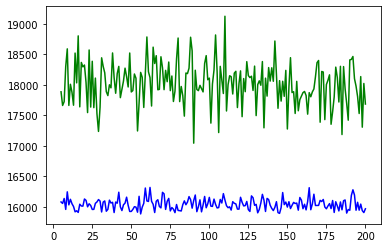

In [20]:
points = generate_points(72, 'normal4')
check_parameters(points, 200)

Jak widać, wyższa temperatura nie wpływa na polepszenie procesu optymalizacji. Za to sposób generowania nowych stanów jest w tym przypadku kluczowy, ponieważ z wykresu możemy wywnioskować, iż sposób zamiany miejscami dwóch wierzchołków połączonych w ścieżce (`consecutive-swap`) daje o wiele lepsze rezultaty (tj. zwraca ścieżkę o znacznie niższym koszcie).